In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath(os.path.join( os.getcwd(), '..')))
# Import organization

import pandas as pd
from ogb.linkproppred import PygLinkPropPredDataset, Evaluator
import torch 
from matplotlib import pyplot as plt
from visual import load_csv
from torch_geometric import utils
from torch_geometric.utils import to_torch_coo_tensor, coalesce 
import numpy as np
from scipy.sparse import coo_matrix, csr_matrix

from core.heuristic.lsf import CN, AA, RA, InverseRA
from core.heuristic.gsf import Ben_PPR, shortest_path, katz_apro, katz_close, SymPPR
from core.data_utils.load import load_data_lp
from core.data_utils.lcc import use_lcc
from core.graphgps.utility.utils import init_cfg_test
from visual import (find_opt_thres, 
                    get_metric_invariant, 
                    load_results, 
                    plot_pos_neg_histogram, 
                    tensor_to_csr_matrix, 
                    eval_mix_heuristic, 
                    save_error_examples)

/home/hk-project-test-p0021478/cc7738/anaconda3/envs/TAG-LP/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


   edge_index0  edge_index1      pred   gr
0         7068        11114  6.722300  1.0
1         3586        11465  4.245617  1.0
2         2461        12599  6.289268  1.0
3         1962         2170  4.745151  1.0
4         7295         8537  6.202402  1.0


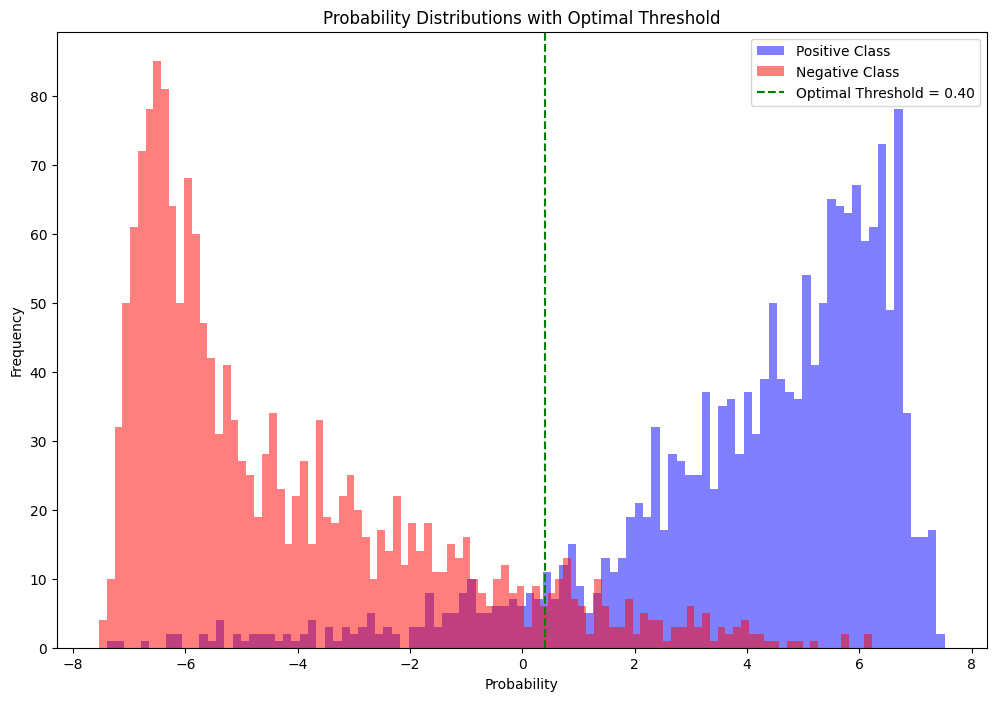

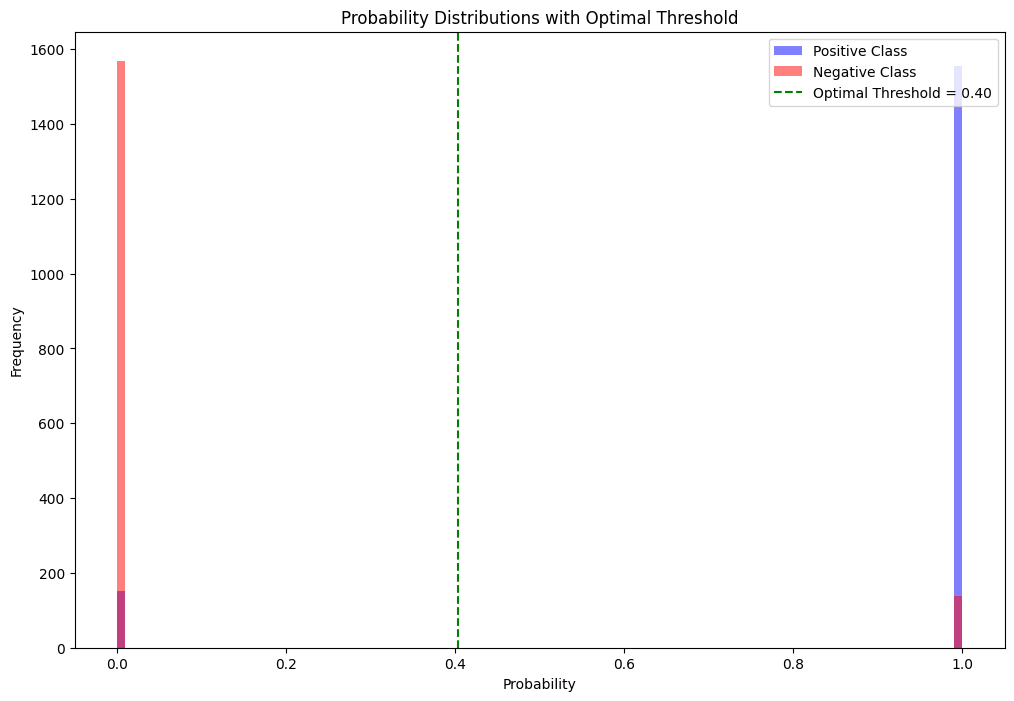

original num of nodes: 46198
create graph: 0.4711005687713623
[13153]
num of nodes after lcc: 13153
num of edges after lcc: 68260
num of texts in dataset: 13153


In [2]:
notebook_dir = os.getcwd()  
target_dir = os.path.abspath(os.path.join(notebook_dir, '..'))

sys.path.insert(0, target_dir)

evaluator_hit = Evaluator(name='ogbl-collab')
evaluator_mrr = Evaluator(name='ogbl-citation2')

# Example usage
FILE_PATH = '/hkfs/work/workspace/scratch/cc7738-benchmark_tag/educational_demo/'
ncnc_cora_path = FILE_PATH + 'err_ncnc_llama/ncnc-arxiv_2023_AUC_0.9701_MRR_0.2946.csv'

# optimal threshold detection
P1, P2, pos_index, neg_index = load_results(ncnc_cora_path)
best_thres, best_acc, pos_pred, neg_pred = find_opt_thres(P1, P2)

plot_pos_neg_histogram(P1, P2, best_thres)
plot_pos_neg_histogram(pos_pred, neg_pred, best_thres)

cfg = init_cfg_test()
cfg.data.name = 'arxiv_2023'
splits, text, data = load_data_lp[cfg.data.name](cfg.data)
# type 2 predict no when yes 

20it [00:00, 26.36it/s]


<Figure size 640x480 with 0 Axes>

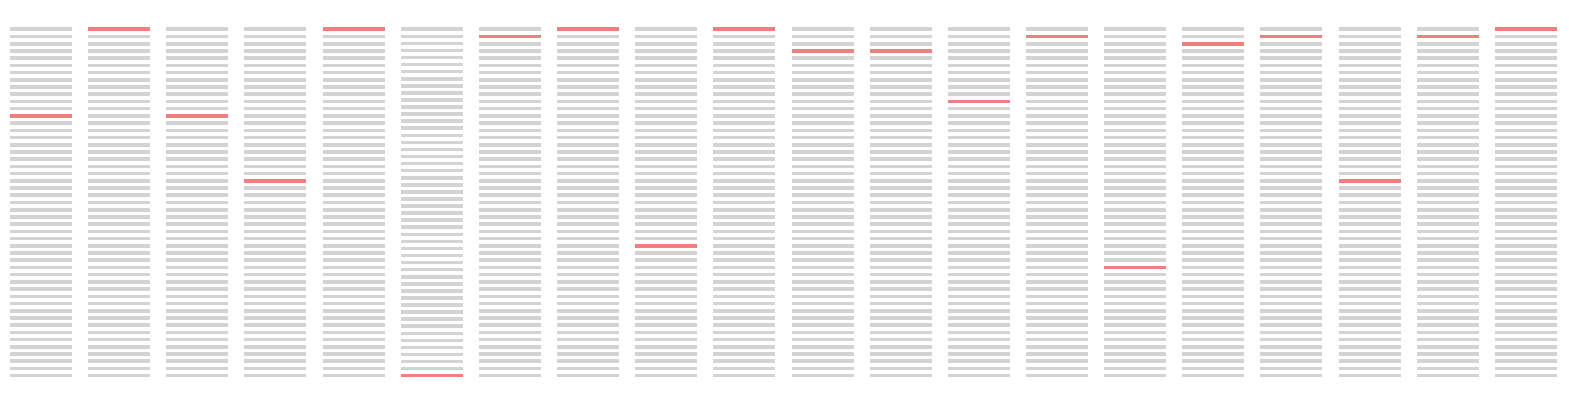

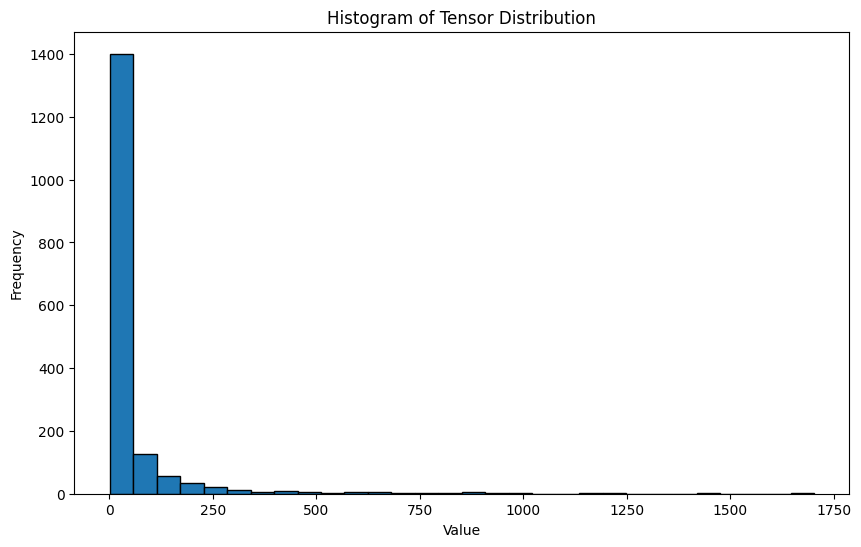

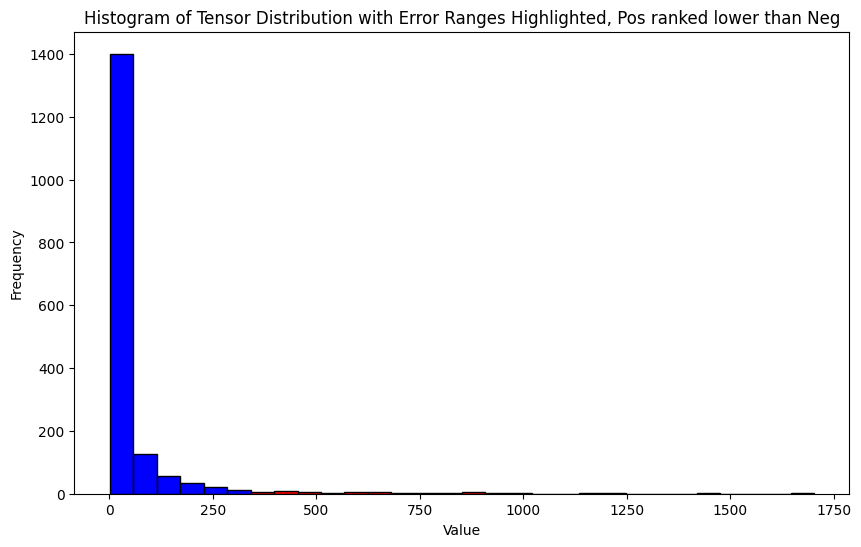

20it [00:00, 28.73it/s]


<Figure size 640x480 with 0 Axes>

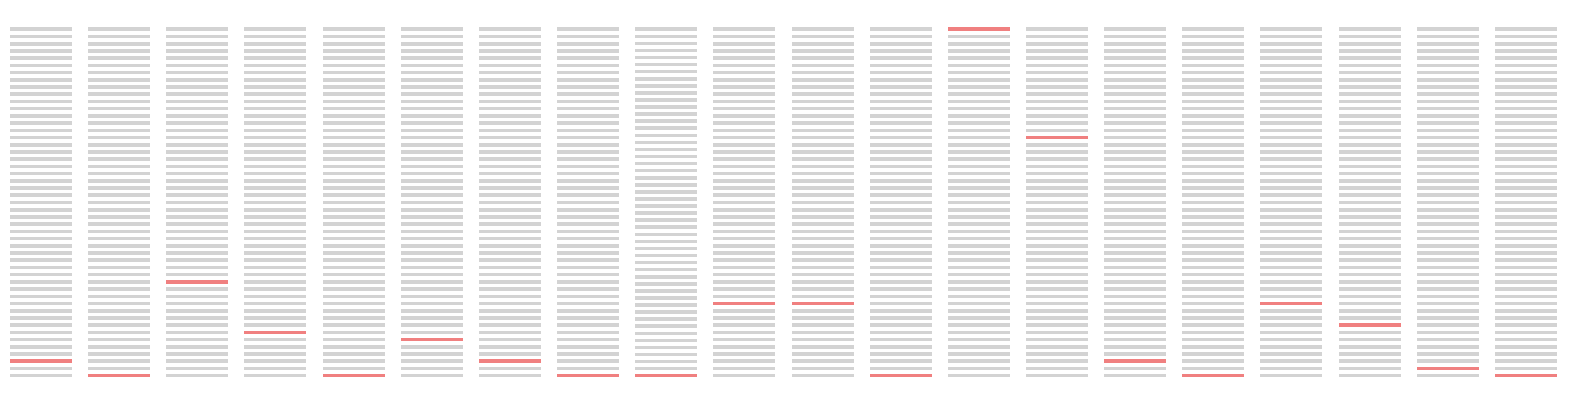

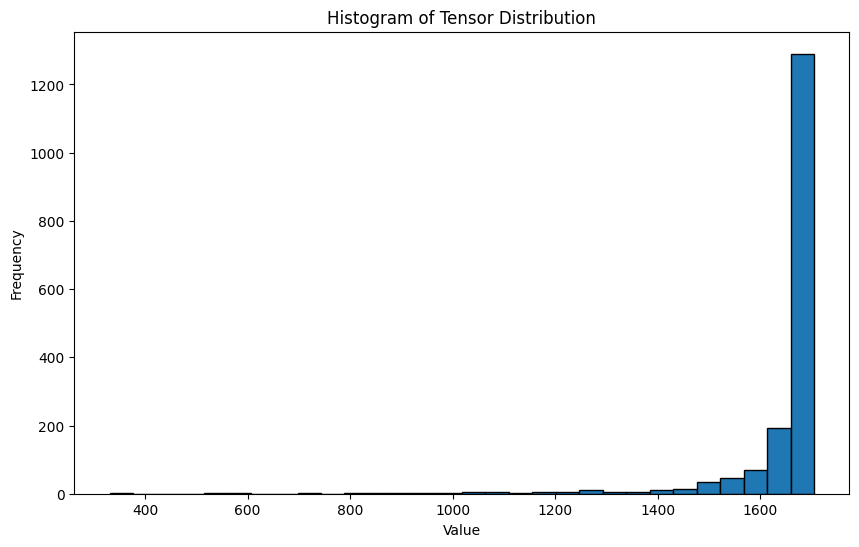

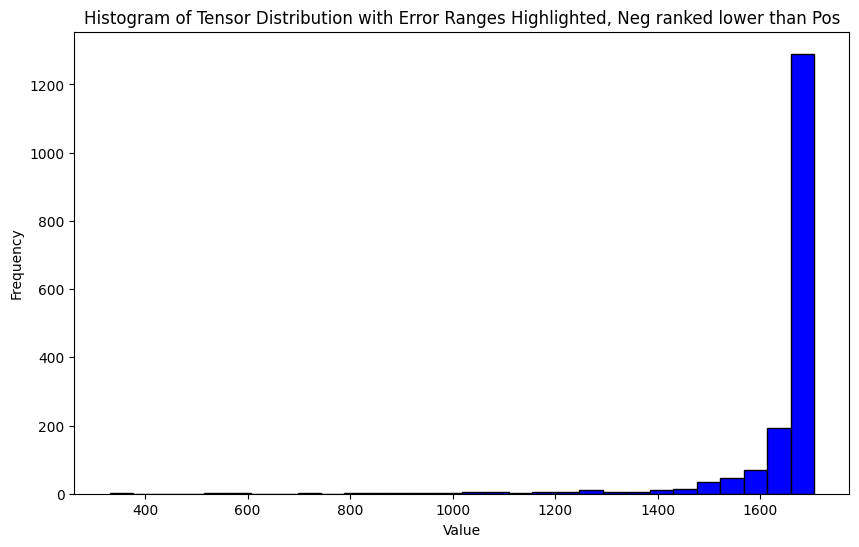

100%|██████████| 1/1 [00:00<00:00, 443.94it/s]


evaluated Common Neighbours for 56 edges


100%|██████████| 1/1 [00:00<00:00, 418.05it/s]


evaluated Adamic Adar for 56 edges


100%|██████████| 1/1 [00:00<00:00, 633.87it/s]
/hkfs/work/workspace/scratch/cc7738-benchmark_tag/TAPE_chen/core/heuristic/lsf.py:48: RuntimeWarning: overflow encountered in exp
  multiplier = np.exp(A.sum(axis=0))


evaluated Resource Allocation for 56 edges


100%|██████████| 1/1 [00:00<00:00, 471.16it/s]


evaluated InverseRA for 56 edges


100%|██████████| 56/56 [00:01<00:00, 30.28it/s]


evaluated PPR for 56 edges
remove:  False


100%|██████████| 56/56 [00:00<00:00, 24232.03it/s]

evaluated shortest path for 56 edges


remove:  False


100%|██████████| 56/56 [00:00<00:00, 438.76it/s]

evaluated katz apro for 56 edges



100%|██████████| 56/56 [00:00<00:00, 56394.00it/s]


evaluated katz close for 56 edges


100%|██████████| 112/112 [00:02<00:00, 43.62it/s]


evaluated SymPPR for 56 edges


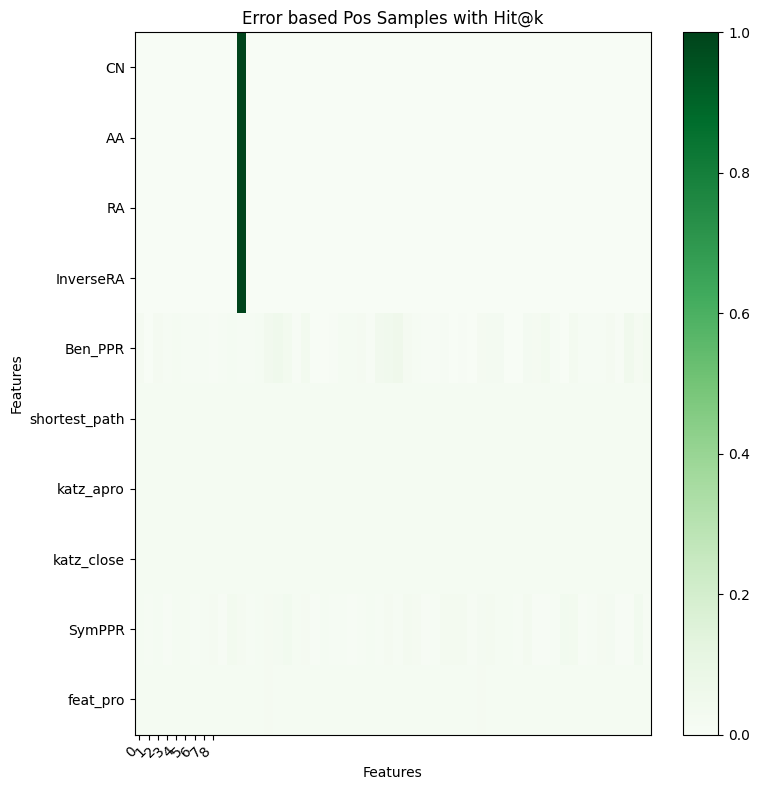

In [6]:
k_list  = [0.1, 0.2, 0.3, 0.5, 1]
mrr_pos2neg, mrr_neg2pos, result_auc_test, pos_edge_index_err, pos_rank_err, neg_edge_index_err, neg_rank_err = get_metric_invariant(P1, pos_index, P2, neg_index, k_list)

# pos
norm_feat_pos = eval_mix_heuristic(data, pos_edge_index_err)

feature_names = ['CN', 'AA', 'RA', 'InverseRA', 'Ben_PPR', 'shortest_path', 'katz_apro', 'katz_close', 'SymPPR', 'feat_pro']
index_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8']
plt.figure(figsize=(8, 8))
plt.imshow(norm_feat_pos, cmap='Greens', aspect='auto')
plt.colorbar()
plt.xticks(ticks=np.arange(len(index_names)), labels=index_names, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(feature_names)), labels=feature_names)
plt.xlabel('Features')
plt.ylabel('Features')
plt.title('Error based Pos Samples with Hit@k')
plt.tight_layout()
plt.show()


In [4]:

norm_feat_neg = eval_mix_heuristic(data, neg_edge_index_err)
feature_names = ['CN', 'AA', 'RA', 'InverseRA', 'Ben_PPR', 'shortest_path', 'katz_apro', 'katz_close', 'SymPPR', 'feat_pro']
index_names = ['0']
plt.figure(figsize=(8, 8))
plt.imshow(norm_feat_neg, cmap='Greens', aspect='auto')
plt.colorbar()
plt.xticks(ticks=np.arange(len(index_names)), labels=index_names, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(feature_names)), labels=feature_names)
plt.xlabel('Features')
plt.ylabel('Features')
plt.title('Feature Map Heatmap')
plt.tight_layout()
plt.savefig('neg_err_map.png')
plt.close()


100%|██████████| 1/1 [00:00<00:00, 394.02it/s]


evaluated Common Neighbours for 4 edges


100%|██████████| 1/1 [00:00<00:00, 414.33it/s]


evaluated Adamic Adar for 4 edges


100%|██████████| 1/1 [00:00<00:00, 325.92it/s]


evaluated Resource Allocation for 4 edges


100%|██████████| 1/1 [00:00<00:00, 353.71it/s]


evaluated InverseRA for 4 edges


100%|██████████| 4/4 [00:00<00:00, 38.38it/s]


evaluated PPR for 4 edges
remove:  False


100%|██████████| 4/4 [00:00<00:00, 4274.45it/s]

evaluated shortest path for 4 edges


remove:  False


100%|██████████| 4/4 [00:00<00:00, 409.69it/s]

evaluated katz apro for 4 edges



100%|██████████| 4/4 [00:00<00:00, 16288.56it/s]


evaluated katz close for 4 edges


100%|██████████| 8/8 [00:00<00:00, 42.71it/s]
/hkfs/work/workspace/scratch/cc7738-benchmark_tag/TAPE_chen/analysis/visual.py:426: RuntimeWarning: invalid value encountered in divide
  normalized_feat = heuristic_feat / row_sums


evaluated SymPPR for 4 edges


In [7]:
type_2 = pos_index[pos_pred == 0]
print(f'{len(type_2)} type 2 errors are detected.')

# type 1 predict yes when no
type_1 = neg_index[neg_pred == 1]
print(f'{len(type_1)} type 1 errors are detected.')


df = save_error_examples(type_2, text)
print(df.head)
df.to_csv('type_2_arxiv_llama_cora.csv', index=False)

df = save_error_examples(type_1, text)
print(df.head)
df.to_csv('type_1_arxiv_llama_cora.csv', index=False)

152 type 2 errors are detected.
138 type 1 errors are detected.
<bound method NDFrame.head of                                                 Source  \
0    Title: Language acquisition: do children and l...   
1    Title: Do We Still Need Clinical Language Mode...   
2    Title: CHiLS: Zero-Shot Image Classification w...   
3    Title: Neuralangelo: High-Fidelity Neural Surf...   
4    Title: Estudio de la Experiencia de Usuario me...   
..                                                 ...   
147  Title: Aligning Text-to-Image Models using Hum...   
148  Title: Visual-Language Prompt Tuning with Know...   
149  Title: Generative Image Dynamics\nAbstract: We...   
150  Title: Blocks2World: Controlling Realistic Sce...   
151  Title: Breaking the Bank with ChatGPT: Few-Sho...   

                                                Target  
0    Title: Information-Restricted Neural Language ...  
1    Title: Towards More Robust NLP System Evaluati...  
2    Title: Unsupervised Prototype Ada